In [25]:
"""
VAE allows a probabilistic sampling of the latent space. This creates a generative model
that can be applied to better classify/predict specific values or generate new ones.


This is an example; thus, typical MLOps are more complex involving additional functionalities.



"""

'\nVAE allows a probabilistic sampling of the latent space. This creates a generative model\nthat can be applied to better classify/predict specific values or generate new ones.\n\n\nThis is an example; thus, typical MLOps are more complex involving additional functionalities.\n\nThis example explores what can happen if we also learn mu and std during training to sample the Gaussian distribution.\n\n'

In [ ]:
#Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras import backend as K

from keras.datasets import fashion_mnist

from sklearn.metrics import classification_report

In [ ]:
#Load data
(X_train,y_train),(X_test,y_test)=fashion_mnist.load_data()

#Prepare data

#Scale values
X_train=X_train.astype('float32')/255.0
X_test=X_test.astype('float32')/255.0

#Reshape arrays to include a channel information fot the image
X_train=X_train.reshape(-1,28,28,1)
X_test=X_test.reshape(-1,28,28,1)


print("Train data",X_train.shape)
print("Test data",X_test.shape)

print("Train labels",y_train[1:10])

4422102/4422102 [==============================] - 0s 0us/step
Train data (60000, 28, 28, 1)
Test data (10000, 28, 28, 1)
Train labels [0 0 3 0 2 7 2 5 5]


In [27]:
#Define key parameters for the model

IMG_SHAPE=(28,28,1)
BATCH=256
L_DIM=2 #latent dimension
EPOCHS=100
FILTERS=16

#Define early stopping
ES=keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

#Define sampling function

def sample(args):
  z_mean,z_log_var=args
  epsilon=K.random_normal(shape=(K.shape(z_mean)[0],L_DIM),mean=0.0,stddev=1.0)
  return z_mean+K.exp(0.5*z_log_var)*epsilon


In [28]:
#Define the encoder model

#NOTE there are various potential architectures for setting up decoder, encoder and VAE
#Gaussian noise added can follow normal distribution; however, in this case we organise
#the parameters to be leant for the optimal sampling


inputs=tf.keras.Input(shape=IMG_SHAPE)

h=inputs
filters=FILTERS

for i in range(2):
  filters*=2
  h=tf.keras.layers.Conv2D(filters,(3,3),strides=2,activation='relu',padding='same')(h)
  

#Get output shape
SHAPE=K.int_shape(h)

h=tf.keras.layers.Flatten()(h)

h=tf.keras.layers.Dense(256,activation='relu')(h)
h=tf.keras.layers.Dropout(0.2)(h)
h=tf.keras.layers.Dense(128,activation='relu')(h)
h=tf.keras.layers.Dropout(0.2)(h)
h=tf.keras.layers.Dense(64,activation='relu')(h)
h=tf.keras.layers.Dropout(0.2)(h)
h=tf.keras.layers.Dense(16,activation='relu')(h)
h=tf.keras.layers.Dropout(0.2)(h)

z_mean=tf.keras.layers.Dense(L_DIM,name='z_mean')(h)
z_log_var=tf.keras.layers.Dense(L_DIM,name='z_log_var')(h)

#Link sampling function with keras layers using Lambda

z=tf.keras.layers.Lambda(sample)([z_mean,z_log_var])

encoder=tf.keras.Model(inputs,[z_mean,z_log_var,z],name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 14, 14, 32)   320         ['input_6[0][0]']                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d_6[0][0]']               
                                                                                                  
 flatten_3 (Flatten)            (None, 3136)         0           ['conv2d_7[0][0]']               
                                                                                            

In [29]:
print(SHAPE)

(None, 7, 7, 64)


In [30]:
#Define the decoder model

latent_inputs=tf.keras.Input(shape=(L_DIM,))

h=latent_inputs


h=tf.keras.layers.Dense(16,activation='relu')(h)
h=tf.keras.layers.Dense(64,activation='relu')(h)
h=tf.keras.layers.Dense(128,activation='relu')(h)
h=tf.keras.layers.Dense(256,activation='relu')(h)

h=tf.keras.layers.Dense(np.prod(SHAPE[1:]),activation='relu')(h)
h=tf.keras.layers.Reshape(SHAPE[1:])(h)


for i in range(2):
  
  h=tf.keras.layers.Conv2DTranspose(filters,(3,3),activation='relu',padding='same',strides=2)(h)

  filters//=2


outputs=tf.keras.layers.Conv2DTranspose(1,(3,3),activation='sigmoid',padding='same')(h)

decoder=tf.keras.Model(latent_inputs,outputs,name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_26 (Dense)            (None, 16)                48        
                                                                 
 dense_27 (Dense)            (None, 64)                1088      
                                                                 
 dense_28 (Dense)            (None, 128)               8320      
                                                                 
 dense_29 (Dense)            (None, 256)               33024     
                                                                 
 dense_30 (Dense)            (None, 3136)              805952    
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 64)          0   

In [31]:
#Define VAE

outputs=decoder(encoder(inputs)[2])
vae=tf.keras.Model(inputs,outputs,name='VAE')
vae.summary()

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 2),               864148    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         904113    
                                                                 
Total params: 1,768,261
Trainable params: 1,768,261
Non-trainable params: 0
_________________________________________________________________


In [32]:
#Define loss function

loss=tf.keras.losses.binary_crossentropy(K.flatten(inputs),K.flatten(outputs))*np.prod(IMG_SHAPE)
KL_loss=K.sum(1+z_log_var-K.square(z_mean)-K.exp(z_log_var),axis=-1)*-0.5
vae_loss=K.mean(loss+KL_loss)
vae.add_loss(vae_loss)

vae.compile(optimizer='adam')

In [33]:
vae.fit(X_train,X_train,epochs=EPOCHS,batch_size=BATCH,validation_split=0.2,callbacks=[ES])

Epoch 1/100
188/188 [==============================] - 6s 24ms/step - loss: 379.8286 - val_loss: 305.8470
Epoch 2/100
188/188 [==============================] - 4s 19ms/step - loss: 301.8072 - val_loss: 284.5674
Epoch 3/100
188/188 [==============================] - 4s 22ms/step - loss: 292.2011 - val_loss: 278.6544
Epoch 4/100
188/188 [==============================] - 4s 22ms/step - loss: 288.2527 - val_loss: 274.7754
Epoch 5/100
188/188 [==============================] - 4s 21ms/step - loss: 285.7938 - val_loss: 273.7448
Epoch 6/100
188/188 [==============================] - 5s 25ms/step - loss: 283.9240 - val_loss: 271.7134
Epoch 7/100
188/188 [==============================] - 4s 21ms/step - loss: 282.6797 - val_loss: 270.5287
Epoch 8/100
188/188 [==============================] - 4s 19ms/step - loss: 281.4853 - val_loss: 269.9045
Epoch 9/100
188/188 [==============================] - 4s 21ms/step - loss: 280.2563 - val_loss: 268.9547
Epoch 10/100
188/188 [========================

In [38]:
#Visualise the encoder latent mean and sigma

encoded_mean,ecoded_log_var,encoded_z=encoder.predict(X_test)

313/313 [==============================] - 1s 2ms/step


In [39]:
encoded_mean.shape

(10000, 2)

In [40]:
len(encoded_mean[:,1])

10000

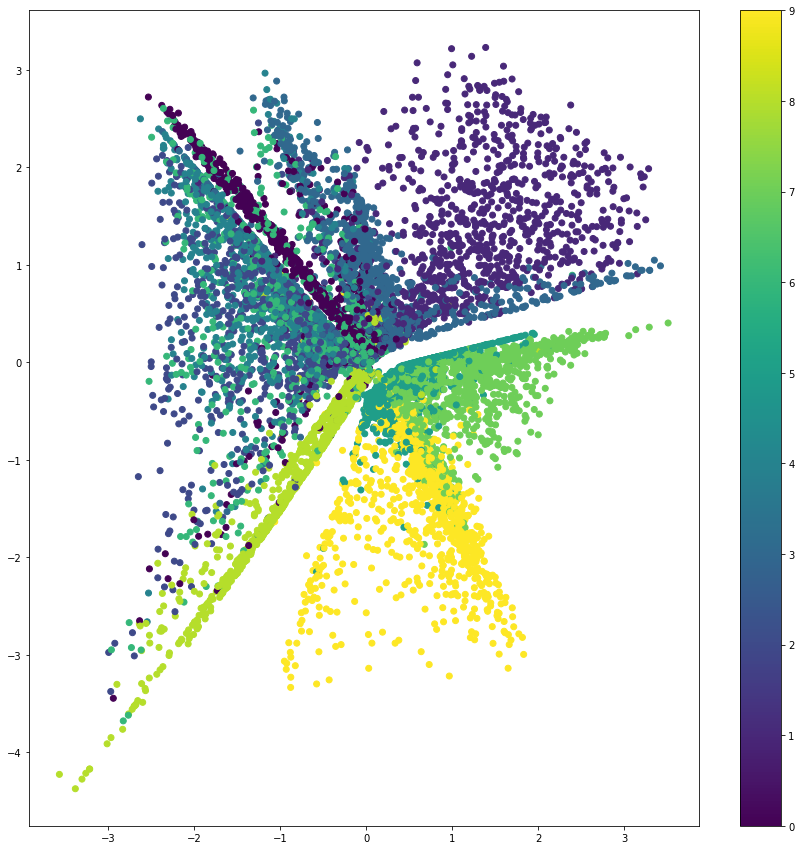

In [41]:
plt.figure(figsize=(15,15))
plt.scatter(encoded_mean[:,0],encoded_mean[:,1],c=y_test)
plt.colorbar()
plt.show()

1/1 [==============================] - 0s 15ms/step


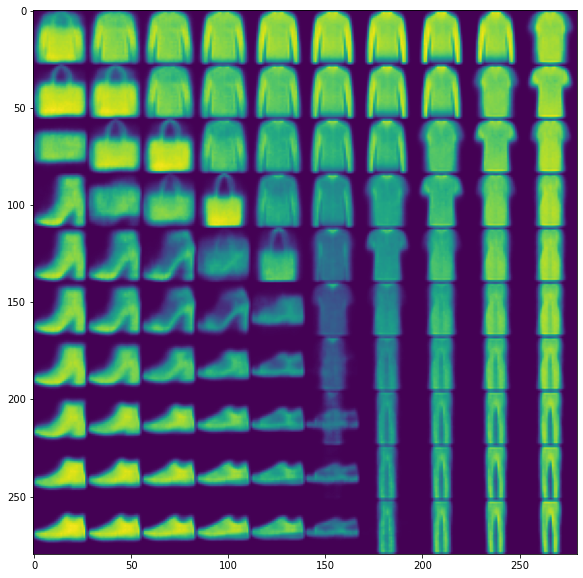

In [42]:
n=10

img_size=28
fig=np.zeros((n*img_size,n*img_size))

grid_x=np.linspace(-1,1,n)
grid_y=np.linspace(-1,1,n)

for i,xi in enumerate(grid_x):
  for j,yi in enumerate(grid_y):

    z_sample=np.array([[xi,yi]])
    decoded_img=decoder.predict(z_sample)

    img=decoded_img[0].reshape(img_size,img_size)
    

    fig[i*img_size:(i+1)*img_size,j*img_size:(j+1)*img_size,]=img

plt.figure(figsize=(10,10))
plt.imshow(fig)
plt.show()